<a href="https://colab.research.google.com/github/mirianbatista/regressao-linear-multipla/blob/master/regressao_linear_mortalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
indicadores = 'ANO', 'Codmun7', 'UF', 'Município', 'ESPVIDA', 'FECTOT', 'MORT1', 'SOBRE60', 'T_ENV', 'E_ANOSESTUDO', 'T_ANALF11A14', 'T_ANALF25M', 'T_ATRASO_0_BASICO', 'T_ATRASO_2_BASICO', 'T_FLPRE', 'T_FLSUPER', 'T_FREQSUPER1517', 'T_SUPER25M', 'T_MED25M', 'GINI', 'PIND', 'PINDCRI', 'PMPOB', 'PMPOBCRI', 'RDPC', 'CPR', 'EMP', 'P_AGRO', 'P_COM', 'P_CONSTR', 'P_EXTR', 'P_FORMAL', 'P_FUND', 'P_MED', 'P_SERV', 'P_SIUP', 'P_SUPER', 'T_DES2529', 'TRABCC', 'TRABPUB', 'TRABSC', 'T_AGUA', 'T_BANAGUA', 'T_DENS', 'T_LIXO', 'T_LUZ', 'AGUA_ESGOTO', 'PAREDE', 'T_CRIFUNDIN_TODOS', 'T_FORA4A5', 'T_FORA6A14', 'T_FUNDIN_TODOS', 'T_FUNDIN_TODOS_MMEIO', 'T_FUNDIN18MINF', 'T_M10A14CF', 'T_M15A17CF', 'T_MULCHEFEFIF014', 'T_NESTUDA_NTRAB_MMEIO', 'T_OCUPDESLOC_1', 'T_RMAXIDOSO', 'T_SLUZ', 'HOMEMTOT', 'MULHERTOT', 'pesoRUR', 'pesotot', 'pesourb', 'POP', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R' 
idhm = pd.read_excel('https://github.com/mirianbatista/idhm-pb/blob/master/atlas2013_dadosbrutos_pt.xlsx?raw=true', sheet_name=1, usecols = indicadores, dtype = {'UF': str, 'Codmun7':str}) 
idhmpb = idhm.groupby(idhm['UF']).get_group('25').loc[(idhm['ANO'] == 2010)] 
get_covid = requests.get("https://brasil.io/api/dataset/covid19/caso/data/?search=&date=&state=PB&city=&place_type=&is_last=True&city_ibge_code=&order_for_place=").json()
covidpb = pd.DataFrame.from_dict(get_covid['results'])

In [ ]:
idhmcovidpb = pd.merge(idhmpb, covidpb, left_on="Codmun7", right_on="city_ibge_code", how="left") 
idhmcovid = idhmcovidpb.loc[(idhmcovidpb['estimated_population_2019'] > 10000)]
idhmcovid.head()

,ANO,UF,Codmun7,Município,ESPVIDA,FECTOT,MORT1,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_2_BASICO,T_FLPRE,T_FLSUPER,T_FREQSUPER1517,T_MED25M,T_SUPER25M,GINI,PIND,PINDCRI,PMPOB,PMPOBCRI,RDPC,CPR,EMP,P_AGRO,P_COM,P_CONSTR,P_EXTR,P_FORMAL,P_FUND,P_MED,P_SERV,P_SIUP,P_SUPER,T_DES2529,TRABCC,TRABPUB,...,T_DENS,T_LIXO,T_LUZ,AGUA_ESGOTO,PAREDE,T_CRIFUNDIN_TODOS,T_FORA4A5,T_FORA6A14,T_FUNDIN_TODOS,T_FUNDIN_TODOS_MMEIO,T_FUNDIN18MINF,T_M10A14CF,T_M15A17CF,T_MULCHEFEFIF014,T_NESTUDA_NTRAB_MMEIO,T_OCUPDESLOC_1,T_RMAXIDOSO,T_SLUZ,HOMEMTOT,MULHERTOT,pesoRUR,pesotot,pesourb,POP,IDHM,IDHM_E,IDHM_L,IDHM_R,city,city_ibge_code,confirmed,confirmed_per_100k_inhabitants,date,death_rate,deaths,estimated_population_2019,is_last,order_for_place,place_type,state
0,2010,25,2500106,ÁGUA BRANCA,67.72,1.87,34.9,77.84,8.52,7.87,3.99,35.20,45.98,28.01,51.70,8.44,0.00,15.29,3.86,0.54,29.14,36.15,46.27,59.27,233.65,17.42,0.51,43.92,9.24,10.26,0.0,28.33,35.28,24.48,30.61,2.88,5.58,7.38,12.25,13.24,...,31.17,98.53,99.44,17.55,0.16,51.54,30.01,2.41,43.35,32.62,64.23,0.88,4.67,28.02,26.04,0.77,6.50,0.56,4719,4730,5388,9449,4061,9444,0.572,0.484,0.712,0.542,Água Branca,2500106,75,732.85128,2020-10-05,0.0267,2,10234.0,True,136,city,PB
2,2010,25,2500304,ALAGOA GRANDE,72.83,2.52,19.5,86.44,10.74,7.78,8.09,43.82,37.98,38.69,59.27,7.71,0.46,14.49,2.91,0.53,17.77,27.59,39.36,58.80,287.94,24.93,1.52,42.22,11.78,7.19,0.0,24.91,32.12,22.78,32.44,0.96,4.45,11.59,15.32,6.54,...,36.22,91.89,98.76,15.94,7.38,58.79,21.59,2.64,53.56,41.88,67.82,0.00,6.35,37.45,24.33,3.16,7.51,1.24,13861,14618,10948,28479,17531,28432,0.582,0.430,0.797,0.576,Alagoa Grande,2500304,1596,5600.78608,2020-10-05,0.0175,28,28496.0,True,163,city,PB
3,2010,25,2500403,ALAGOA NOVA,69.93,2.01,27.6,81.72,9.52,8.97,4.65,36.49,48.69,31.53,69.02,8.57,0.33,12.40,3.79,0.54,21.43,35.28,43.82,63.23,272.81,30.22,0.47,51.10,11.14,4.15,0.0,24.88,30.97,18.46,26.39,0.28,4.86,8.60,11.50,9.96,...,32.26,99.12,99.66,27.20,0.61,61.70,12.92,2.15,51.86,40.57,67.40,0.43,7.92,23.47,20.49,1.14,6.32,0.34,9761,9920,9887,19681,9794,19674,0.576,0.451,0.749,0.567,Alagoa Nova,2500403,354,1697.92316,2020-10-05,0.0254,9,20849.0,True,165,city,PB
4,2010,25,2500502,ALAGOINHA,72.72,2.55,19.8,86.28,9.18,9.01,5.87,46.08,50.20,30.94,56.32,6.08,0.00,14.29,4.54,0.52,16.72,24.26,42.05,58.50,284.64,26.14,0.09,42.71,10.90,13.29,0.0,35.56,33.81,21.33,28.61,1.05,6.15,12.48,19.74,8.26,...,31.86,97.09,98.44,17.21,10.59,55.69,15.40,1.29,47.52,36.10,60.26,0.00,8.63,22.21,20.04,2.15,6.83,1.56,6704,6872,4542,13576,9034,13528,0.595,0.462,0.795,0.574,Alagoinha,2500502,1053,7267.58230,2020-10-05,0.0114,12,14489.0,True,153,city,PB
7,2010,25,2500601,ALHANDRA,71.69,2.71,22.5,84.65,5.68,8.67,7.26,33.51,51.18,29.21,48.67,2.12,0.00,16.36,1.82,0.45,17.03,24.40,39.52,53.94,236.14,23.50,0.28,34.31,12.41,8.83,0.0,36.59,37.87,25.93,37.03,1.05,2.95,17.82,30.13,4.53,...,35.30,90.73,99.00,10.31,10.58,52.90,21.36,3.69,46.95,36.64,60.05,0.00,8.77,21.13,29.18,1.57,5.21,1.00,8864,9143,6854,18007,11153,17891,0.582,0.465,0.778,0.544,Alhandra,2500601,666,3400.04084,2020-10-05,0.0270,18,19588.0,True,158,city,PB


In [ ]:
correlacao_positiva = idhmcovid.corr().loc['death_rate'].sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
fig = go.Figure(data=go.Scatter(x=correlacao_positiva['death_rate'], y=correlacao_positiva['indicador'], mode='markers', text=idhmcovid['Município'])) 
fig.update_layout(title="Indicadores do IDHM com maior correlação positiva de mortalidade de COVID-19")
fig.show()

In [ ]:
corr_positiva= idhmcovid[['T_OCUPDESLOC_1','TRABCC','T_M10A14CF','T_AGUA','P_SERV']]
mortalidade = idhmcovid.death_rate

In [ ]:
xtrain_corr_positiva, xtest_corr_positiva, ytrain_corr_positiva, ytest_corr_positiva = train_test_split(corr_positiva, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_positiva = LinearRegression()
linreg_corr_positiva.fit(xtrain_corr_positiva, ytrain_corr_positiva)
print('linear model coeff (w): {}'
.format(linreg_corr_positiva.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_positiva.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_positiva.score(xtrain_corr_positiva, ytrain_corr_positiva)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_positiva.score(xtest_corr_positiva, ytest_corr_positiva)))

linear model coeff (w): [3.38745064e-03 2.25599182e-04 7.85402194e-03 8.63584149e-05
 2.14484624e-04]
linear model intercept (b): -0.005
R-squared score (training): 0.257
R-squared score (test): -0.142


In [ ]:
ipred_corr_positiva = linreg_corr_positiva.predict(xtest_corr_positiva)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_positiva, ipred_corr_positiva))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_positiva, ipred_corr_positiva))

Mean squared error: 0.00
Coefficient of determination: -0.14


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_positiva, y=ipred_corr_positiva, mode='markers', text=idhmcovid['Município'])) 
fig.update_layout(title="Valores reais e previstos de correlação positiva de mortalidade de COVID-19")
fig.show()

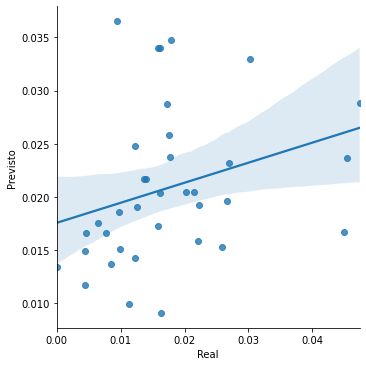

In [ ]:
df_corr_positiva = pd.DataFrame ({'Real': ytest_corr_positiva, 'Previsto': ipred_corr_positiva}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_positiva);

In [ ]:
correlacao_negativa = idhmcovid.corr().loc['death_rate'].sort_values().to_frame().reset_index().rename(columns = {'index': 'indicador'})[:10]
fig = go.Figure(data=go.Scatter(x=correlacao_negativa['death_rate'], y=correlacao_negativa['indicador'], mode='markers', text=idhmcovid['Município'])) 
fig.update_layout(title="Indicadores do IDHM com maior correlação negativa de mortalidade de COVID-19")
fig.show()

In [ ]:
corr_negativa = idhmcovid[['T_RMAXIDOSO','AGUA_ESGOTO','T_FUNDIN18MINF','CPR','T_ENV']]

In [ ]:
xtrain_corr_negativa, xtest_corr_negativa, ytrain_corr_negativa, ytest_corr_negativa = train_test_split(corr_negativa, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_negativa = LinearRegression()
linreg_corr_negativa.fit(xtrain_corr_negativa, ytrain_corr_negativa)
print('linear model coeff (w): {}'
.format(linreg_corr_negativa.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_negativa.intercept_))
print('R-squared score (training): {:.3f}'
.format(linreg_corr_negativa.score(xtrain_corr_negativa, ytrain_corr_negativa)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_negativa.score(xtest_corr_negativa, ytest_corr_negativa)))

linear model coeff (w): [-0.00111982 -0.00038996  0.00015329 -0.00103896 -0.00024901]
linear model intercept (b): 0.054
R-squared score (training): 0.148
R-squared score (test): -0.421


In [ ]:
ipred_corr_negativa = linreg_corr_negativa.predict(xtest_corr_negativa)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_negativa, ipred_corr_negativa))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_negativa, ipred_corr_negativa))

Mean squared error: 0.00
Coefficient of determination: -0.42


In [ ]:
fig = go.Figure(data=go.Scatter(x=ytest_corr_negativa, y=ipred_corr_negativa, mode='markers', text=idhmcovid['Município'])) 
fig.update_layout(title="Valores reais e previstos de correlação negativa de mortalidade de COVID-19")
fig.show()

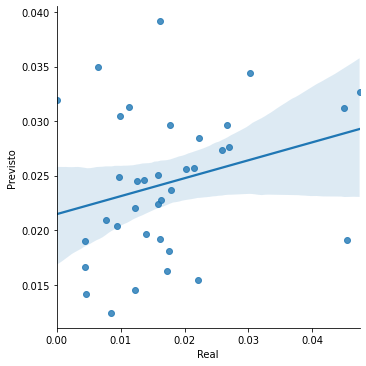

In [ ]:
df_corr_negativa = pd.DataFrame ({'Real': ytest_corr_negativa, 'Previsto': ipred_corr_negativa}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_negativa)